# Recency Frequency Monetary (RFM) Model Implementation<a class='tocSkip'>

In [1]:
# Display matplotlib plots
%matplotlib inline

# Loading Libraries
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
from collections import Counter;
import operator;

The database used to answer this question was created using [creating_database.sql](supplementary_files/creating_database.sql) file. A 


The code for this file can be accessed by clicking the button `Show Code` Button on the top of this document or by opening the attached Jupyter file.


preview of the structure of the table is presented below:

<img src="supplementary_files/rfm.pdf">

## Part A

### Step 1

The following steps were taken to create the view called rfm in the supplementary file - [creating_rfm_view.sql](supplementary_files/creating_rfm_view.sql):

* A  training dataset was created by splitting the dataset through time.
    
    * The training dataset had data from 2005/01/01 to 2015/12/31. The data before this was ignored since the communication for the company started in 2015.
    
    * Only the catalogue channel was used since we have to optimise by catalogue mailings.
         
         
* Different views for Recency, Frequency and Monetary were created.
    
    * To create the Recency view, the difference between the maximum order date and 2015/12/31 for all the customers was taken (using group by *cust_id*). All the entries were then sorted in the ascending order of this metric. An N-tile SQL Window function was used to split the data into *quantiles*. In this case this column can be found in the Recency view as *r*.
    * To create the Frequency view, distinct order numbers for each user was calculated. This column can be found as 'f' in the frequency view.
    * Finally, to create the Monetary view, average expenditure was calculated for each user, and then the N-tile window function was used to split the customers into quantiles.
    
    
* All the different views were then combined using *cust_id*. Results can be found in rfm_pre view.
    
    * r,f,m were combined using the concat sql function. This view was sorted in decreasing order by using the following command *ORDER BY r DESC, f DESC, m DESC*.
    
    
* Finally, rfm view was created which had *cust_id* and the rfm groupings.


> **RFM view (First 10 enteries)**

In [2]:
rfm_view_datapath = r'supplementary_files/rfm.csv'
rfm_view = pd.read_csv(rfm_view_datapath)
rfm_view.head(10)

,cust_id,rfm
0,80122261,555
1,61370030,555
2,80109834,555
3,51980180,555
4,77662754,555
5,53287061,555
6,64299989,555
7,70438213,555
8,51950369,555
9,47716532,555


---

### Step 2

The next step was now to calculate the response rate for the training dataset. Please refer to the supplementary file - [creating_response_view.sql](supplementary_files/creating_response_view.sql):

The main decision for calculating the response rate was to decide the cut-off which will be used to attribute the order to the specific catalogue mailing.

To answer this mean, median and mode of the time between customer's order and `Max` contact date was computed. Finally, 10 was used as the cut-off. 10 was choosen because if half of the reorders are given after 13 days then the catalogue must pursuade the buyers to purchase earlier. A range of cut-offs were tried and 10 was chosen on the face value of the results obtained.

>**Visualisation to decide the cut-off point for categorising an order as a response to the contact made by the company**

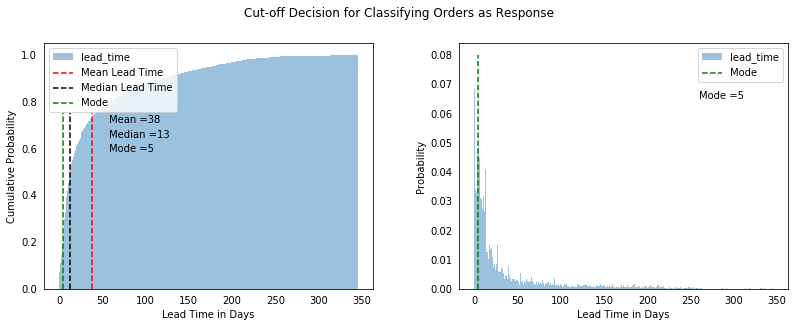

In [3]:
# Laoding Data
cut_off_datapath = r'supplementary_files/cut_off_decision.csv'
cut_off_data = pd.read_csv(cut_off_datapath)

dictionary = dict()
for i in cut_off_data.lead_time:
    if i not in dictionary.keys():
        dictionary[i] = 1
    else:
        dictionary[i] += 1


lead_mean=np.mean(cut_off_data.lead_time)
lead_median=np.median(cut_off_data.lead_time)
mode = max(dictionary, key=lambda k: dictionary[k])
cut_off = mode

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(121)
ax.hist(cut_off_data.lead_time, len(dictionary.keys()), density=True, cumulative=True, alpha = 0.45)
ax.vlines(lead_mean, ymin=0, ymax=0.75, label= 'Mean Lead Time', colors='red', linestyles='dashed')
ax.text(lead_mean+20, .71, 'Mean =' + str(round(lead_mean)))
ax.vlines(lead_median, ymin=0, ymax=0.75, label= 'Median Lead Time', linestyles='dashed')
ax.text(lead_mean+20, .645, 'Median =' + str(int(lead_median)))
ax.vlines(cut_off, ymin=0, ymax=.75, label= 'Mode', linestyles='dashed', colors='green')
ax.text(lead_mean+20, .585, 'Mode =' + str(cut_off))
ax.set(ylabel='Cumulative Probability', xlabel='Lead Time in Days')
ax.tick_params(bottom = False, top = False, left = False, right = False)
plt.legend()

ax2 = plt.subplot(122)
ax2.hist(cut_off_data.lead_time, len(dictionary.keys()), density=True, alpha = 0.45)
ax2.tick_params(bottom = False, top = False, left = False, right = False)
ax2.set(ylabel='Probability', xlabel='Lead Time in Days')
ax2.vlines(cut_off, ymin=0, ymax=.08, label= 'Mode', linestyles='dashed', colors='green')
ax2.text(260, .065, 'Mode =' + str(cut_off))
plt.legend()

plt.suptitle('Cut-off Decision for Classifying Orders as Response')
plt.tight_layout(pad=4)
plt.show()

The visualisation of the cumulative probability and the probability of the lead time of the customer in the training data (2005/01/01 - 2005/12/31) shows the three measures of central tendency - mean, median and mode.

After deciding the cut-off, the following steps were undertaken to create the optimising view:

* A response view was created for the customers that we grouped into RFM categories. The training data was used to do this.

    * *CASE WHEN* function in sql was used to categorise the lead time of the customer as a response.
    * A summation of the responses grouped by RFM categories was taken to create the *responses_grouped* view. 
    
    
* A similar approach was taken for the contacts view. All the contacts made to the customers in the same time range was calculated.

    * A summation of the contacts grouped by RFM categories was taken to create the *contacts_grouped* view.
    
    
* The *responses_grouped* view and the *contacts_grouped* view were joined on *rfm* column.
    
    * The response_rate view shows the calculation used to calculate the response rate. All the responses made by a specific RFM group were divided by the contacts made to that RFM group.
    
    
* Finally, the profits of mailing to the RFM categories were calculated using the information provided on the revenue and cost of mailing.

    * Cumulative profits were calculated and a cutoff point till the row where the profits were increasing was used to decide the RFM groups that were going to be targeted in the test data. This approach is also presented in the visualisation below.

> **Optimizing view (First 10 enteries)**

In [4]:
optimizing_view_datapath = r'supplementary_files/optimizing.csv'
optimizing_view = pd.read_csv(optimizing_view_datapath)
optimizing_view.head(10)

,rfm,response_rate,total_cost,expected_responses,expected_revenue,expected_profits,cumulative_responses,cumulative_profits
0,451,0.3808,154,58.6432,1759.296,1605.296,58.6432,1605.296
1,452,0.2865,276,79.0740,2372.220,2096.220,137.7172,3701.516
2,453,0.2150,286,61.4900,1844.700,1558.700,199.2072,5260.216
3,454,0.2120,280,59.3600,1780.800,1500.800,258.5672,6761.016
4,352,0.2081,446,92.8126,2784.378,2338.378,351.3798,9099.394
5,413,0.2045,325,66.4625,1993.875,1668.875,417.8423,10768.269
6,441,0.1915,68,13.0220,390.660,322.660,430.8643,11090.929
7,552,0.1896,367,69.5832,2087.496,1720.496,500.4475,12811.425
8,455,0.1885,228,42.9780,1289.340,1061.340,543.4255,13872.765
9,351,0.1877,360,67.5720,2027.160,1667.160,610.9975,15539.925


>**Gain Chart to decide the RFM groups to mail in the training dataset (>2006/01/01) to decide RFM cut-off**

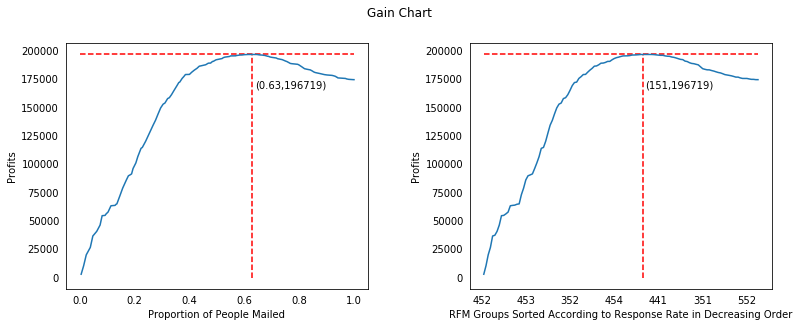

In [6]:
# Laoding Data
gain_chart_datapath = r'supplementary_files/gain_chart.csv'
gain_chart_data=pd.read_csv(gain_chart_datapath)
x = list(range(1,126))
gain_chart_data['index'] = x

# Plotting Maximum point
maximum_point = max(gain_chart_data.cumulative_profits)
maximum_point_prop = 0
for index, i in enumerate(gain_chart_data.cumulative_profits):
    if i == maximum_point:
        maximum_point_prop=gain_chart_data.cumulative_proportion[index]
maximum_rfm= 0
for index, i in enumerate(gain_chart_data.cumulative_profits):
    if i == maximum_point:
        maximum_rfm=gain_chart_data.rfm[index]
maximum_index= 0
for index, i in enumerate(gain_chart_data.cumulative_profits):
    if i == maximum_point:
        maximum_index=gain_chart_data.index[index]     
    
    
# X-axis adjustment
rfm = list(gain_chart_data.rfm)

# Plotting
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(121)
ax.plot(gain_chart_data.cumulative_proportion, gain_chart_data.cumulative_profits)
ax.tick_params(bottom = False, top = False, left = False, right = False)
ax.set(ylabel='Profits', xlabel='Proportion of People Mailed')
ax.hlines(maximum_point, xmin=0, xmax=1, colors='red', linestyles='dashed')
ax.vlines(maximum_point_prop, ymin=0, ymax=maximum_point, linestyles='dashed', colors='red')
ax.text(maximum_point_prop+0.01, maximum_point-30000, '(' + str(round(maximum_point_prop,2)) + ',' +  str(round(maximum_point)) + ')')    

ax2 = plt.subplot(122)
ax2.plot(x, gain_chart_data.cumulative_profits)
ax2.set_xticklabels(rfm, rotation = 0.0)
ax2.tick_params(bottom = False, top = False, left = False, right = False)
ax2.set(ylabel='Profits', xlabel='RFM Groups Sorted According to Response Rate in Decreasing Order')
ax2.hlines(maximum_point, xmin=1, xmax=125, colors='red', linestyles='dashed')
ax2.vlines(maximum_index, ymin=0, ymax=maximum_point, linestyles='dashed', colors='red')
ax2.text(maximum_index + 1, maximum_point-30000, '(' + str(maximum_rfm) + ',' +  str(round(maximum_point)) + ')')    

plt.suptitle('Gain Chart')
plt.tight_layout(pad = 4)
plt.show()

---

### Step 3

After deciding the RFM groups to target, this strategy was tested out on the test dataset (>2006/01/01). To calculate the final return on investment please follow [creating_roi_view.sql](supplementary_files/creating_roi_view.sql).

To calculate the final ROI the following steps were undertaken:

* A contacted view was created which had all *cust_id* for all the customers that were going to be targeted.
    
    * A N-Tile(125) function was used to sort the RFM groups according to the response rate. This was done so that only the RFM groups above the cut-off points could be isolated out and contacted.
    

* Responses for the customers classified in the RFM groups were identified if the order date - contact date was within the first 10 days. 

    * These resposnses were then grouped according to the RFM groups (test_total_response_by_rfm_group).
    
    
* A similar approach was taken for the contacts as explained in the training dataset. Contacts made only to the RFM groups were calculated and summed to create the view test_total_contacts_by_rfm_group.


* The grouped contacts view and the response view were joined on rfm.

    * This was done to calculate the response rate per RFM group.
    
    
* Finally the ROI was calculated (as shown below). For more information please refer to the end of the [creating_roi_view.sql](supplementary_files/creating_roi_view.sql) file.



---

### Results (ROI and Lift Chart)

**ROI after RFM targetting**

In [7]:
roi_datapath = r'supplementary_files/roi.csv'
roi = pd.read_csv(roi_datapath)
roi

,total_contacts,total_responses,total_reveue,total_profit,roi
0,263571,9637,289110,25539,9.69


**ROI after sending a mail to all or after applying random sampling**

In [8]:
roi_all_datapath = r'supplementary_files/roi_all.csv'
roi_all = pd.read_csv(roi_all_datapath)
roi_all

,total_contacts,total_responses,total_reveue,total_profit,roi
0,349876,11197,335910,-13966,-3.99


>**Lift chart to see how the RFM targeting has performed against a random targeting approach**

The lift chart here shows that the RFM targetting performs better compared to random mailing or mailing to everyone. 

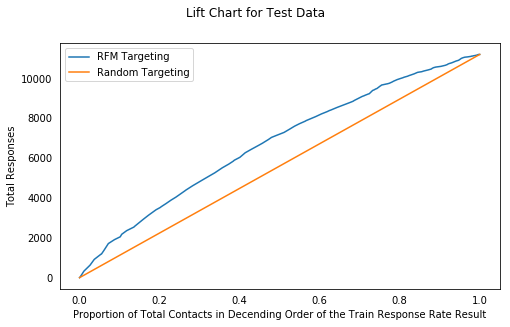

In [9]:
# Loading Data
lift_data_path = r'supplementary_files/lift.csv'
lift_data = pd.read_csv(lift_data_path)

# Calculating average response rate
avg_response_rate = np.mean(lift_data.response_rate)

# Plotting Data Prep
p1 = [0,1]
p2 = [0,lift_data.cumulative_responses[124]]
cumulative_response_list = [0]
cumulative_proportion_list = [0]
for i in lift_data.cumulative_responses:
    cumulative_response_list.append(i)
for i in lift_data.cumulative_proportion:
    cumulative_proportion_list.append(i)

# Plotting
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)
ax.plot(cumulative_proportion_list, cumulative_response_list, label = 'RFM Targeting')
ax.plot(p1, p2, label = 'Random Targeting')
ax.set(ylabel='Total Responses', xlabel='Proportion of Total Contacts in Decending Order of the Train Response Rate Result')
ax.tick_params(bottom = False, top = False, left = False, right = False)
plt.legend()
plt.suptitle('Lift Chart for Test Data')
plt.tight_layout(pad = 4)

---

##  Part B

A similar data split was used in this section to make the findings consistent. So training dataset contained observations between 2005 and 2006 and the test dataset had all observations after 2006/01/01. All the steps used to construct the analysis below can be found in the [rfm_addition.sql](supplementary_files/rfm_addition.sql) file.

---

###  Justification based on business sense

Another dimension which can be used to do the targeting can be **average spend by zip code**. This measure will capture the high spending areas and will allow the business to promote its product in a neighbourhood. This adds to the RFM targetting as people living in the same neighbourhood might share some network effects. Thus adopting this strategy will allow the business to take advantage of word-of-mouth.

---

###  Justification based on validation sample

Similar steps were followed as discussed in part a to calculate the roi and create a lift chart. Although the lift chart is not directly comparable, since there were a lot more categories compared to 125 categories in RFM targetting, it still shows a similar performance compared to the RFM targetting. We can see that there was an improvement of 1% in the final ROI.

>**Gain Chart to decide the RFM groups to mail in the training dataset (>2006/01/01) to decide RFM cut-off**

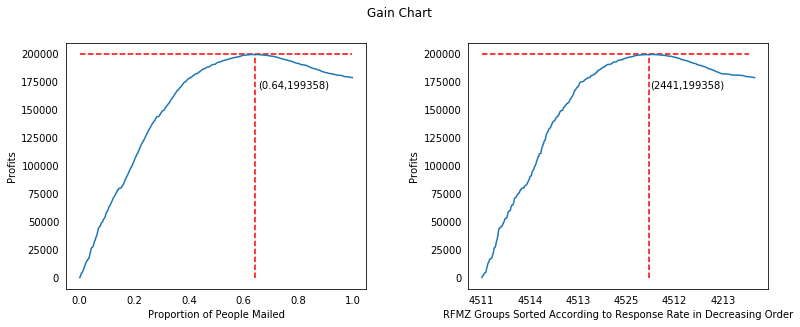

In [5]:
# Laoding Data
gain_chart_datapath = r'supplementary_files/gain_chart_2b.csv'
gain_chart_data=pd.read_csv(gain_chart_datapath)
x = list(range(1,len(gain_chart_data) + 1))
gain_chart_data['index'] = x

# Plotting Maximum point
maximum_point = max(gain_chart_data.cumulative_profits)
maximum_point_prop = 0
for index, i in enumerate(gain_chart_data.cumulative_profits):
    if i == maximum_point:
        maximum_point_prop=gain_chart_data.cumulative_proportion[index]
maximum_rfmz= 0
for index, i in enumerate(gain_chart_data.cumulative_profits):
    if i == maximum_point:
        maximum_rfmz=gain_chart_data.rfmz[index]
maximum_index= 0
for index, i in enumerate(gain_chart_data.cumulative_profits):
    if i == maximum_point:
        maximum_index=gain_chart_data.index[index]     
    
    
# X-axis adjustment
rfmz = list(gain_chart_data.rfmz)

# Plotting
fig = plt.figure(figsize=(12,5))
ax = plt.subplot(121)
ax.plot(gain_chart_data.cumulative_proportion, gain_chart_data.cumulative_profits)
ax.tick_params(bottom = False, top = False, left = False, right = False)
ax.set(ylabel='Profits', xlabel='Proportion of People Mailed')
ax.hlines(maximum_point, xmin=0, xmax=1, colors='red', linestyles='dashed')
ax.vlines(maximum_point_prop, ymin=0, ymax=maximum_point, linestyles='dashed', colors='red')
ax.text(maximum_point_prop+0.01, maximum_point-30000, '(' + str(round(maximum_point_prop,2)) + ',' +  str(round(maximum_point)) + ')')    

ax2 = plt.subplot(122)
ax2.plot(x, gain_chart_data.cumulative_profits)
ax2.set_xticklabels(rfmz, rotation = 0.0)
ax2.tick_params(bottom = False, top = False, left = False, right = False)
ax2.set(ylabel='Profits', xlabel='RFMZ Groups Sorted According to Response Rate in Decreasing Order')
ax2.hlines(maximum_point, xmin=1, xmax=555, colors='red', linestyles='dashed')
ax2.vlines(maximum_index, ymin=0, ymax=maximum_point, linestyles='dashed', colors='red')
ax2.text(maximum_index + 1, maximum_point-30000, '(' + str(maximum_rfmz) + ',' +  str(round(maximum_point)) + ')')    

plt.suptitle('Gain Chart')
plt.tight_layout(pad = 4)
plt.show()

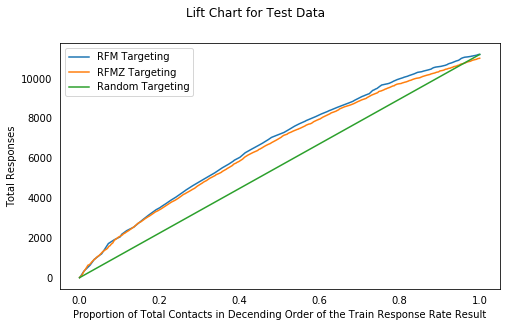

In [9]:
# Loading Data
lift_data_path_2b = r'supplementary_files/lift_2b_avg.csv'
lift_data_2b = pd.read_csv(lift_data_path_2b)

# Plotting Data Prep
cumulative_response_list_2b = [0]
cumulative_proportion_list_2b = [0]
for i in lift_data_2b.cumulative_responses:
    cumulative_response_list_2b.append(i)
for i in lift_data_2b.cumulative_proportion:
    cumulative_proportion_list_2b.append(i)

# data Prep    
# cumulative_response_list_2b_updated = [0]
# cumulative_proportion_list_2b_updated = [0]
# for index,i in enumerate(lift_data.cumulative_proportion):
#     cumulative_proportion_loop = 0
#     cumulative_response_loop = 0
#     while i >= cumulative_proportion_loop:
#         c = 0
#         cumulative_proportion_loop = cumulative_proportion_loop + lift_data_2b.cumulative_proportion[c]
#         cumulative_response_loop = cumulative_response_loop + lift_data_2b.cumulative_responses[c]
#         c += 1
#     cumulative_proportion_list_2b_updated.append(cumulative_proportion_loop)
#     cumulative_response_list_2b_updated.append(cumulative_response_loop)

# Plotting
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111)
ax.plot(cumulative_proportion_list, cumulative_response_list, label = 'RFM Targeting')
ax.plot(cumulative_proportion_list_2b, cumulative_response_list_2b, label = 'RFMZ Targeting')
ax.plot(p1, p2, label = 'Random Targeting')
ax.set(ylabel='Total Responses', xlabel='Proportion of Total Contacts in Decending Order of the Train Response Rate Result')
ax.tick_params(bottom = False, top = False, left = False, right = False)
plt.legend()
plt.suptitle('Lift Chart for Test Data')
plt.tight_layout(pad = 4)

>**ROI after RFMZ targetting**

In [11]:
roi_rfmz_datapath = r'supplementary_files/roi_rfmz.csv'
roi_rfmz = pd.read_csv(roi_rfmz_datapath)
roi_rfmz

,total_contacts,total_responses,total_reveue,total_profit,roi
0,256399,9450,283500,27101,10.57


**RFMZ targetting improves the roi by approximately one percent.**

---